<!--
---
title: "Random forest regression. K nearest neighbor regression"
author: "Madhura Killedar"
exercises: 30
keypoints: 
- Random forests can be combined to solve regression tasks
- kNN is a method that can also be used for regression
source: Rmd
start: 0
teaching: 30
bibliography: references.bib
---
-->


## Random forest regression. K nearest neighbor regression

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import seaborn as sns
import pickle

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.utils import resample


# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [14]:
# load from previous lessons
cached_files = ['models/ames_train_y.pickle','models/ames_test_y.pickle',
                'models/ames_train_X.pickle','models/ames_test_X.pickle',
                'models/predictors.pickle','models/ames_ols_all.pickle',
                'models/ames_ridge.pickle','models/ames_lasso.pickle', 
                'models/ames_enet.pickle']

for file in cached_files:
    with open(file, 'rb') as f:
        objectname = file.replace('models/', '').replace('.pickle', '')
        exec(objectname + " = pickle.load(f)")
        f.close()

In [21]:
list(np.arange(3,11,1))

[3, 4, 5, 6, 7, 8, 9, 10]

## Random Forest
In random forest, each tree in the ensemble is built from a bootstrap sample from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is the best split among a random subset of the features.

In [15]:
# tuning grid was defined to optimise the following RF parameters:
param_grid = {"n_estimators": list(np.arange(10,160,10)),
            'max_depth': list(np.arange(3,11,1)),
            'min_samples_split': [0.005, 0.01, 0.02],
             'max_features': ['sqrt', 'auto']}


This was optimised on the HPC (we'll see some sample scripts for this in the next session), and the best outcome of this ended up being:

```
{'max_depth': 9, 'min_samples_split': 0.005, 
'max_features': 'auto', 'n_estimators': 150}

# best score
0.8735794018428228
```


In [34]:
from sklearn.ensemble import RandomForestRegressor

ames_RF = Pipeline([
    ('estimator', RandomForestRegressor(n_estimators=150, 
                                       max_depth = 9,
                                       min_samples_split = 0.005,
                                       max_features = 'auto'))
    #('estimator', GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', cv=10))
])



## Toggle comment below to build model
ames_RF.fit(ames_train_X, ames_train_y)
pickle.dump(ames_RF, open('models/ames_rforest.pickle', 'wb'))
with open('models/ames_rforest.pickle', 'rb') as f:
    ames_RF = pickle.load(f)

In [35]:
best_RF = ames_RF.named_steps.estimator.best_estimator_
print(best_RF)

Pipeline(memory=None,
     steps=[('estimator', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])


> ## Challenge 1
>
> 1. Try different hyperparameters, how does it impact the feature importances and RMSE (see below)?
> 
> {: .source}
>
{: .challenge}

In [36]:
def plot_coefficients(model, labels):
    importance = model.feature_importances_

    table = pd.Series(importance.ravel(), index = labels).sort_values(ascending=True, inplace=False)
    
    reference = pd.Series(np.abs(importance.ravel()), index = labels).sort_values(ascending=False, inplace=False)
    reference = reference.iloc[:20]
    table = table[reference.index]
    table = table.sort_values(ascending=True, inplace=False)

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Feature Importances (twenty largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

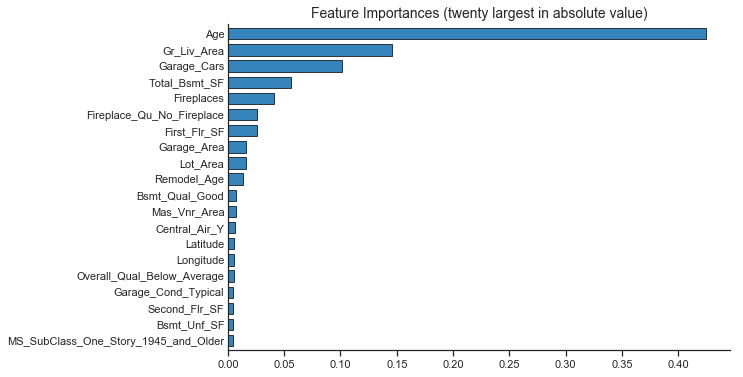

In [37]:
plot_coefficients(best_RF, predictors)
plt.show()

## k-Nearest Neighbours Regression

In [42]:
# tuning grid will be defined to optimise the following knn parameters:
param_grid = {"n_neighbors": list(np.arange(3,21,2)),
              "weights": ['uniform','distance'],
             }

# print(ames_kNN.named_steps['estimator'].best_score_)
#0.7842456772785913
# KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=7, p=2, weights='distance')





In [66]:
from sklearn.neighbors import KNeighborsRegressor

# Next, let's try to tune locally, trying 6, 7 and 8 neighbors:
param_grid = {"n_neighbors": [6,7,8],
              "weights": ['uniform']}


ames_kNN = Pipeline([
    ('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('estimator', KNeighborsRegressor(n_neighbors=10))
    ('estimator', GridSearchCV(KNeighborsRegressor(), param_grid, scoring='r2', cv=10))
])


## Toggle comment below to build model
#ames_kNN.fit(ames_train_X, ames_train_y)
#pickle.dump(ames_kNN, open('models/ames_knn.pickle', 'wb'))
with open('models/ames_knn.pickle', 'rb') as f:
    ames_kNN = pickle.load(f)

print(ames_kNN.named_steps['estimator'].best_estimator_)
print(ames_kNN.named_steps['estimator'].best_score_)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=7, p=2,
          weights='uniform')
0.7810186506203685


## Compare Models

In [67]:
# What was the RMSE on the training data?
columns=['Train RMSE']
rows=['OLS','Ridge', 'Lasso', 'ENet', 'Random Forest', 'k Nearest Neighbours']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_RF, ames_kNN]

for i, method in enumerate(methods):
    y_pred=method.predict(ames_train_X)
    results.iloc[i,0] = np.sqrt(mean_squared_error(10**ames_train_y, 10**y_pred))

results.round(2)

,Train RMSE
OLS,18810.89
Ridge,21330.85
Lasso,20365.80
ENet,21292.16
Random Forest,16942.96
k Nearest Neighbours,32778.02


In [68]:
# Compare with the test data!
columns=['Test RMSE']
rows=['OLS','Ridge', 'Lasso', 'ENet', 'Random Forest', 'k Nearest Neighbours']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ames_ols_all,  ames_ridge, ames_lasso, ames_enet, ames_RF, ames_kNN]

for i, method in enumerate(methods):
    y_pred=method.predict(ames_test_X)
    results.iloc[i,0] = np.sqrt(mean_squared_error(10**ames_test_y, 10**y_pred))

results.round(2)

,Test RMSE
OLS,64792.91
Ridge,47670.17
Lasso,59592.17
ENet,52482.81
Random Forest,27444.85
k Nearest Neighbours,36781.78
